
# No Smoke Max Fall Isopleth with Photon Flux

This notebook loads the No Smoke Max Fall dataset, enriches each sample with photon flux data from the Synoptic/MesoWest API (station `QHW` – Hawthorne), and renders an ozone isopleth with data points colored by how far their photon flux deviates from the seasonal mean.


In [7]:
import os
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from scipy.interpolate import LSQBivariateSpline

plt.style.use('seaborn-v0_8')
sns.set_context('talk')
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

MESOWEST_TOKEN = os.getenv("MESOWEST_TOKEN")
if not MESOWEST_TOKEN:
    raise ValueError('Please set the MESOWEST_TOKEN environment variable before running this notebook.')

STATION_ID = 'QHW'  # Hawthorne

In [8]:
data_path = Path('../data/utah/nosmoke/No_Smoke_Max_Fall.csv')
no_smoke_df = pd.read_csv(data_path, parse_dates=['dt'])
no_smoke_df.sort_values('dt', inplace=True)
no_smoke_df['dt_hour'] = no_smoke_df['dt'].dt.floor('H')

print(f"Loaded {len(no_smoke_df)} observations spanning {no_smoke_df['dt'].min()} to {no_smoke_df['dt'].max()}.")
no_smoke_df.head()

Loaded 162 observations spanning 2021-09-01 15:00:00 to 2023-09-30 10:00:00.


,NOx,VOC,Ozone,dt,dt_hour
0,4.3,14.1395,80.0,2021-09-01 15:00:00,2021-09-01 15:00:00
1,5.2,27.2669,58.0,2021-09-10 16:00:00,2021-09-10 16:00:00
2,3.2,21.5934,63.0,2021-09-25 15:00:00,2021-09-25 15:00:00
3,3.3,28.0155,64.0,2021-09-26 14:00:00,2021-09-26 14:00:00
4,4.2,27.8623,41.0,2021-09-28 17:00:00,2021-09-28 17:00:00


In [9]:
TIMEZONE = 'America/Denver'
BASE_URL = 'https://api.synopticdata.com/v2/stations/timeseries'


def fetch_synoptic_series(token: str, station: str, start, end, variable: str = 'solar_radiation', obtimezone: str = 'local') -> pd.Series: # I could not find any other solar radiation type variable this seems to only work for solar radiation not the uv stuff
    """Fetch hourly observations for a Synoptic/MesoWest station."""
    params = {
        'token': token,
        'stid': station,
        'start': start.strftime('%Y%m%d%H%M'),
        'end': end.strftime('%Y%m%d%H%M'),
        'vars': variable,
        'obtimezone': obtimezone,
        'output': 'json'
    }
    response = requests.get(BASE_URL, params=params, timeout=30)
    response.raise_for_status()
    payload = response.json()
    summary = payload.get('SUMMARY', {})
    if summary.get('RESPONSE_CODE') != 1 or not payload.get('STATION'):
        raise RuntimeError(f"Synoptic request failed: {summary.get('RESPONSE_MESSAGE')}")

    observations = payload['STATION'][0]['OBSERVATIONS']
    timestamps = pd.to_datetime(observations['date_time'], utc=True)
    local_index = timestamps.tz_convert(TIMEZONE).tz_localize(None)
    values = pd.Series(observations[f'{variable}_set_1'], index=local_index, dtype='float64')
    return values.rename(variable)

In [14]:
start = no_smoke_df['dt'].min() - timedelta(days=1)
end = no_smoke_df['dt'].max() + timedelta(days=1)

solar_radiation = fetch_synoptic_series(MESOWEST_TOKEN, STATION_ID, start, end, variable='solar_radiation')
solar_radiation.index = solar_radiation.index.floor('H') #They give hourly rates.
solar_radiation = solar_radiation.rename('solar_radiation_w_m2')

merged_df = no_smoke_df.merge(solar_radiation, left_on='dt_hour', right_index=True, how='left')
missing_radiation = merged_df['solar_radiation_w_m2'].isna().sum()
if missing_radiation:
    print(f'[INFO] {missing_radiation} samples are missing solar radiation data; consider tightening the Synoptic query window.')

radiation_mean = merged_df['solar_radiation_w_m2'].mean()
merged_df['solar_radiation_delta'] = merged_df['solar_radiation_w_m2'] - radiation_mean

merged_df.drop(columns=['dt_hour'], inplace=True)
merged_df.head()


2021-08-31 09:00:00     42.0
2021-08-31 10:00:00    198.0
2021-08-31 11:00:00    355.0
2021-08-31 12:00:00    517.0
2021-08-31 13:00:00    654.0
                       ...  
2023-10-01 00:00:00      0.0
2023-10-01 01:00:00      0.0
2023-10-01 02:00:00      0.0
2023-10-01 03:00:00      0.0
2023-10-01 04:00:00      0.0
Name: solar_radiation, Length: 18260, dtype: float64
[INFO] 1 samples are missing solar radiation data; consider tightening the Synoptic query window.


,NOx,VOC,Ozone,dt,solar_radiation_w_m2,solar_radiation_delta
0,4.3,14.1395,80.0,2021-09-01 15:00:00,530.0,86.310559
1,5.2,27.2669,58.0,2021-09-10 16:00:00,320.0,-123.689441
2,3.2,21.5934,63.0,2021-09-25 15:00:00,720.0,276.310559
3,3.3,28.0155,64.0,2021-09-26 14:00:00,702.0,258.310559
4,4.2,27.8623,41.0,2021-09-28 17:00:00,440.0,-3.689441


In [11]:
summary_cols = ['solar_radiation_w_m2', 'solar_radiation_delta']
summary_stats = merged_df[summary_cols].agg(['mean', 'std', 'min', 'max']).T
summary_stats


,mean,std,min,max
solar_radiation_w_m2,4.436894e+02,213.333519,0.000000,798.000000
solar_radiation_delta,-1.412259e-15,213.333519,-443.689441,354.310559


[INFO] Knots: [ 61.8228 117.8584], [35.8]


/var/folders/8y/j4zbl6y95zn4hrbsnlzpz6yc0000gn/T/ipykernel_15659/3967300413.py:12: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=8). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  spline = LSQBivariateSpline(x, y, z, knot_x, knot_y, eps=2.002002002101761e-12)


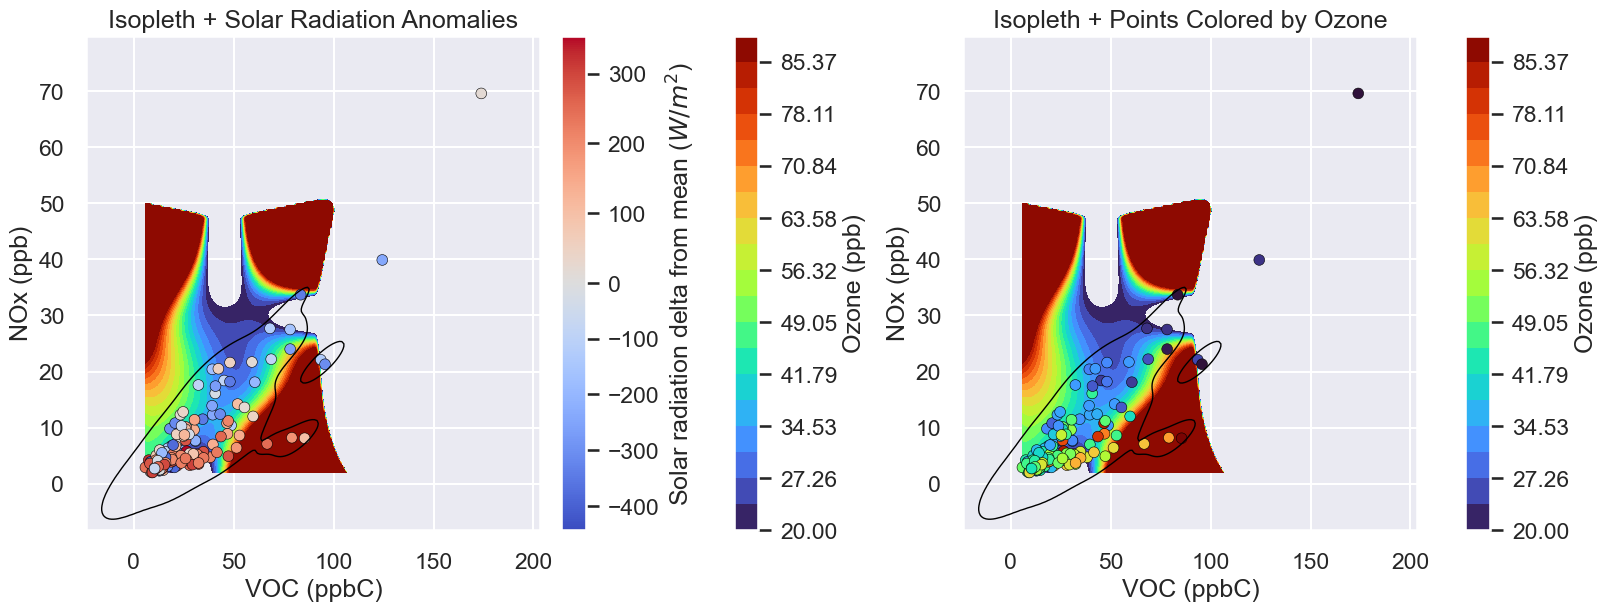

In [13]:
def plot_isopleth_with_radiation(data: pd.DataFrame) -> None:
    x = data['VOC'].astype(float)
    y = data['NOx'].astype(float)
    z = data['Ozone'].astype(float)
    delta = data['solar_radiation_delta'].astype(float)

    knot_x = np.linspace(x.min(), x.max(), 4)[1:-1]
    knot_y = np.linspace(y.min(), y.max(), 3)[1:-1]

    print(f'[INFO] Knots: {knot_x}, {knot_y}')

    spline = LSQBivariateSpline(x, y, z, knot_x, knot_y, eps=2.002002002101761e-12)

    grid_x = np.linspace(x.min(), x.max(), 200)
    grid_y = np.linspace(y.min(), y.max(), 200)
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = spline(grid_x, grid_y)
    ozone_max = z.max()
    ozone_min = z.min()
    # Limit the spline output so it never exceeds the observed max ozone
    Z = np.clip(Z, None, ozone_max)
    # Use levels based on observed data range to avoid plotting beyond data
    contour_levels = np.linspace(ozone_min, ozone_max, 20)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # LEFT: scatter colored by solar radiation delta
    contour0 = axes[0].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    fig.colorbar(contour0, ax=axes[0], pad=0.08, label='Ozone (ppb)')

    norm_delta = TwoSlopeNorm(vmin=delta.min(), vcenter=0, vmax=delta.max())
    scatter0 = axes[0].scatter(
        x, y, c=delta, cmap='coolwarm', norm=norm_delta,
        edgecolor='black', linewidth=0.4, s=60
    )
    fig.colorbar(scatter0, ax=axes[0], pad=0.02,
                 label='Solar radiation delta from mean ($W/m^2$)')

    sns.kdeplot(data=data, x='VOC', y='NOx', ax=axes[0], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[0].set_xlabel('VOC (ppbC)')
    axes[0].set_ylabel('NOx (ppb)')
    axes[0].set_title('Isopleth + Solar Radiation Anomalies')

    # RIGHT: scatter colored by ozone values
    contour1 = axes[1].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    scatter1 = axes[1].scatter(
        x, y, c=z, cmap='turbo', vmin=ozone_min, vmax=ozone_max,
        edgecolor='black', linewidth=0.4, s=60
    )
    fig.colorbar(contour1, ax=axes[1], pad=0.08, label='Ozone (ppb)')

    sns.kdeplot(data=data, x='VOC', y='NOx', ax=axes[1], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[1].set_xlabel('VOC (ppbC)')
    axes[1].set_ylabel('NOx (ppb)')
    axes[1].set_title('Isopleth + Points Colored by Ozone')

    plt.show()

plot_isopleth_with_radiation(merged_df.dropna(subset=['solar_radiation_delta']))
